<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Diffusion_RL/implementation%20attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install einops
!pip install equinox
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 KB 3.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 7.7 MB/s eta 0:00:00


In [27]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx
import numpy as np

In [28]:
key = jr.PRNGKey(2023)

Data generation

In [11]:
def Gaussian(N, mu, sigma, key):
    sg = jr.normal(key, shape=(N,2))
    print(sg.shape)
    g = mu + sigma * sg
    return g

In [13]:
mean1 = jnp.array((0.0, 0.8))
mean2 = jnp.array((0.0, -0.8))
mean3 = jnp.array((0.8, 0.0))
mean4 = jnp.array((-0.8, 0.0))
std = jnp.array((0.05, 0.05))

In [15]:
s1 = Gaussian(2500, mean1, std, key)
s2 = Gaussian(2500, mean2, std, key)
s3 = Gaussian(2500, mean3, std, key)
s4 = Gaussian(2500, mean4, std, key)

(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)


In [16]:
samples = jnp.concatenate([s1, s2, s3, s4], axis=0)

In [24]:
import matplotlib.pyplot as plt

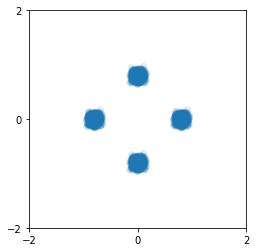

In [25]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

BC-Diffusion

In [32]:
class NeuralNet(eqx.Module):
  main_net: eqx.nn.MLP
  t1: float

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)
    self.t1 = t1

  def __call__(self, t, y):
    t = t / self.t1
    t = einops.repeat(t, "-> 2")
    y = jnp.concatenate([y, t]) #axis =1
    
    y = self.main_net(y)
    return y

In [33]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)

In [34]:
def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))

In [35]:
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state

In [31]:
def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm, :]
            start = end
            end = start + batch_size

In [36]:
t1=10.0
# Optimisation hyperparameters
num_steps=1_000_000
lr=3e-4
batch_size=256
print_every=1_000
# # Sampling hyperparameters
# dt0=0.1
# #sample_size=10
# # Seed
# seed=2023

In [30]:
x = samples.copy()

In [37]:
model_key, train_key, loader_key, sample_key = jr.split(key, 4)
data = x
data_shape = data.shape[1:]

In [39]:
model = NeuralNet(4, 2, 512, 4, key)

In [40]:
int_beta = lambda t: t
weight = lambda t: 1 - jnp.exp(-int_beta(t))  
opt = optax.adabelief(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

In [ ]:
total_value = 0
total_size = 0
losses = [0]
i=0
ls=2


for step, data in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)):
      value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
      total_value += value.item()
      total_size += 1

      if (step % print_every) == 0 or step == num_steps - 1:
              
          print(f"Step={step} Loss={total_value / total_size}")
          if step != 0 :
              ls = total_value / total_size
              if jnp.absolute(ls - losses[i]) > 5e-5:
                  i += 1
                  losses.append(ls)
              else:
                  print("Early stopping intervened")
                  break
          else:
             continue
          total_value = 0
          total_size = 0

Step=0 Loss=1.0422550439834595


In [ ]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1, adjoint=dfx.NoAdjoint())
    return sol.ys[0]

In [ ]:
sample_key = jr.split(sample_key, 1_000)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()